# Model Ensemble for Medical Image Segmentation

### Environment Setup

In [ ]:
# Importing the SSL module to manage secure HTTPS connections
import ssl

# Overriding the default SSL context to ignore SSL certificate verification.
# This bypasses security checks and should only be used for debugging or non-production purposes.
ssl._create_default_https_context = ssl._create_unverified_context


In [ ]:
# Installing specific versions of PyTorch and torchvision for compatibility
!pip install torch==1.11.0 torchvision==0.12.0

# Installing additional libraries for data processing, augmentation, and model summaries
!pip install tqdm pandas numpy albumentations torchsummary pyra_pytorch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 17.8 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.5.1+cu121
    Uninstalling torch-2.5.1+cu121:
      Successfully uninstalled torch-2.5.1+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.20.1+cu121
    Uninstalling torchvision-0.20.1+cu121:
      Successfully uninstalled torchvision-0.20.1+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.13.2 requires torch>=1.13.0, but you have torch 1.11.0 which is incompatible.
torchaudio 2.5.1+cu121 requires torch==2.5.1, but you have torch 1.11.0 which is incompatible.


In [ ]:
# Installing the specified version of the segmentation-models-pytorch library
!pip install segmentation-models-pytorch==0.2.0

# Displaying information about the installed segmentation-models-pytorch package
!pip show segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 13.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12403 sha256=16c591e3821f034a7c66e79aee6900cfd23842addc6b769dfe230dbdaa22bf11
  Stored in directory: /root/.cache/pip/wheels/61/3a/b0/0b4c443c380bd934701b0a25e4aed76479e4fcaf1a6f955664
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=19fa6a1ba65bdae5d85c5786ad885a40821e44cc5842288252eb2a23424f2538
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Attempting uninstall: timm
    Found existing installation

In [ ]:
# Installing the nibabel library for working with neuroimaging file formats
!pip install nibabel

In [ ]:
# Clone the divergent-nets repository from GitHub to the current Colab environment
!git clone https://github.com/vlbthambawita/divergent-nets.git

# Change the current working directory to the cloned divergent-nets repository
%cd divergent-nets


Cloning into 'divergent-nets'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 109 (delta 55), reused 66 (delta 22), pack-reused 0 (from 0)
Receiving objects: 100% (109/109), 2.00 MiB | 8.31 MiB/s, done.
Resolving deltas: 100% (55/55), done.
/content/divergent-nets


In [ ]:
# Importing the Google Colab drive module to mount Google Drive
from google.colab import drive

# Mounting Google Drive to the Colab environment
drive.mount('/content/drive')

# Importing the os module to interact with the file system
import os

# Creating the target directory for data within the cloned repository
os.makedirs('/content/divergent-nets/data', exist_ok=True)

# Creating symbolic links to the training, testing, and validation directories on Google Drive
!ln -s /content/drive/MyDrive/training /content/divergent-nets/data
!ln -s /content/drive/MyDrive/testing /content/divergent-nets/data
!ln -s /content/drive/MyDrive/val /content/divergent-nets/data


Mounted at /content/drive


### Data Loading and Preprocessing

In [ ]:
import torch
import nibabel as nib  # Library for loading NIfTI (.nii.gz) files
import numpy as np
from torch.utils.data import Dataset  # PyTorch Dataset class for custom datasets
from torchvision.transforms import functional as TF  # For image transformations (e.g., resizing)
from sklearn.model_selection import train_test_split  # For splitting datasets

class NiiDataset(Dataset):
    def __init__(self, data_dir, transform=None, desired_size=256):
        self.data_dir = data_dir  # Main directory where the data is stored
        self.transform = transform  # Optional transformations to apply to the data
        self.desired_size = desired_size  # Target size for the input images (e.g., 256x256)
        self.file_pairs = self._collect_file_pairs()  # Collect all image-mask file pairs dynamically

    def _collect_file_pairs(self):
        """
        Collects paths of image files and corresponding mask files.
        Image filenames do not contain '_gt', while mask filenames contain '_gt'.
        """
        file_pairs = []  # List to store pairs of image and mask file paths
        for root, _, files in os.walk(self.data_dir):  # Walk through the data directory
            # Find image files (e.g., '_frame' in filenames, and not '_gt')
            images = sorted([os.path.join(root, f) for f in files if "_frame" in f and f.endswith(".nii.gz") and "_gt" not in f])
            # Find mask files (e.g., '_gt' in filenames)
            masks = sorted([os.path.join(root, f) for f in files if "_frame" in f and f.endswith(".nii.gz") and "_gt" in f])

            # Match images with their corresponding masks
            for img_path in images:
                # Modify image path to get corresponding mask path
                mask_path = img_path.replace(".nii.gz", "_gt.nii.gz")
                if mask_path in masks:  # If a matching mask exists, add the pair
                    file_pairs.append((img_path, mask_path))
                else:
                    print(f"Warning: No matching mask found for {img_path}")  # Print a warning if no matching mask found
        return file_pairs  # Return the list of file pairs

    def __len__(self):
        # Return the total number of samples (image-mask pairs)
        return len(self.file_pairs)

    def __getitem__(self, idx):
        """
        Given an index, loads the image and mask, processes them,
        and returns the processed sample.
        """
        # Get the image and mask paths for the given index
        image_path, mask_path = self.file_pairs[idx]
        # Use nibabel to load the NIfTI (.nii.gz) files
        image_nii = nib.load(image_path)
        mask_nii = nib.load(mask_path)

        # Get the image and mask data as NumPy arrays (shape: [depth, height, width])
        image_data = image_nii.get_fdata()
        mask_data = mask_nii.get_fdata()

        # If the data has an extra dimension, remove it (e.g., if the data is 4D, take the first channel)
        if len(image_data.shape) == 4:
            image_data = image_data[:, :, :, 0]
        if len(mask_data.shape) == 4:
            mask_data = mask_data[:, :, :, 0]

        # Find valid slices where the mask has non-zero values (i.e., where there is a foreground object)
        valid_slices = [i for i in range(mask_data.shape[0]) if np.any(mask_data[i, :, :] > 0)]
        if len(valid_slices) == 0:
            raise ValueError(f"No valid mask slices found for {mask_path}")  # Raise an error if no valid slice is found

        # Randomly select a valid slice for the image and mask
        selected_slice = np.random.choice(valid_slices)

        # Extract the 3 consecutive slices (if possible) from the image
        image_slice = image_data[selected_slice:selected_slice + 3, :, :] if selected_slice + 3 <= image_data.shape[0] else image_data[:3, :, :]
        mask_slice = mask_data[selected_slice, :, :]  # Select the corresponding slice for the mask

        # Binarize the mask (e.g., if values > 0, set them to 1, else set to 0)
        mask_slice = (mask_slice > 0).astype(np.int32)

        # Convert the image and mask slices into PyTorch tensors
        image_tensor = torch.from_numpy(image_slice).float()  # Image tensor (shape: [3, height, width])
        mask_tensor = torch.from_numpy(mask_slice).unsqueeze(0).long()  # Mask tensor (shape: [1, height, width])

        # Resize the image and mask to the desired size (e.g., 256x256)
        image_tensor = TF.resize(image_tensor, [self.desired_size, self.desired_size])
        mask_tensor = TF.resize(mask_tensor, [self.desired_size, self.desired_size])

        # Create a sample dictionary to return
        sample = {'image': image_tensor, 'mask': mask_tensor}

        # Apply any additional transformations, if specified
        if self.transform:
            sample = self.transform(sample)

        return sample  # Return the processed sample

# Paths for training and validation data
data_training = '/content/divergent-nets/data/training'
data_val = '/content/divergent-nets/data/val'

# Create training and validation datasets using the NiiDataset class
desired_size = 256  # Desired input size for the images
train_dataset = NiiDataset(data_dir=data_training, desired_size=desired_size)
val_dataset = NiiDataset(data_dir=data_val, desired_size=desired_size)

# Create a test dataset
test_data_path = '/content/divergent-nets/data/testing'  # Path to testing data
test_dataset = NiiDataset(data_dir=test_data_path, desired_size=desired_size)


### Model Training and Evaluation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from segmentation_models_pytorch import DeepLabV3Plus, FPN  # Example models from segmentation_models_pytorch library
from segmentation_models_pytorch.losses import DiceLoss  # Loss function
from torchvision.transforms import functional as TF
from sklearn.metrics import jaccard_score
import numpy as np
import matplotlib.pyplot as plt

# Data loading function (to be implemented based on the specific dataset)
def load_data():
    # Create DataLoader instances for training, validation, and test datasets
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)  # Shuffle training data
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)  # No shuffle for validation data
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)  # No shuffle for test data

    return train_loader, val_loader, test_loader

# Training function
def train(model, train_loader, val_loader, optimizer, loss_fn, num_epochs=10, device='cuda'):
    model.to(device)  # Move the model to the specified device (GPU or CPU)
    best_val_loss = float('inf')  # Initialize the best validation loss as infinity

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        train_loss = 0  # Initialize training loss for this epoch
        for batch in train_loader:
            # Get images and masks from the batch, move to device
            images = batch['image'].to(device)
            masks = batch['mask'].to(device).long()  # Convert masks to long type (integer class labels)

            optimizer.zero_grad()  # Clear gradients of previous step
            outputs = model(images)  # Forward pass: model produces outputs
            loss = loss_fn(outputs, masks)  # Calculate the loss between outputs and ground truth masks
            loss.backward()  # Backward pass: calculate gradients
            optimizer.step()  # Update model weights using gradients
            train_loss += loss.item()  # Accumulate the loss for the epoch

        train_loss /= len(train_loader)  # Average the training loss over all batches

        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0  # Initialize validation loss
        with torch.no_grad():  # No need to track gradients during validation
            for batch in val_loader:
                # Get images and masks for validation, move to device
                images = batch['image'].to(device)
                masks = batch['mask'].to(device).long()  # Ensure masks are of long type
                outputs = model(images)  # Forward pass for validation
                loss = loss_fn(outputs, masks)  # Calculate the loss for validation
                val_loss += loss.item()  # Accumulate the validation loss

        val_loss /= len(val_loader)  # Average the validation loss over all batches

        # Print training and validation loss for the current epoch
        print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save the best model (with lowest validation loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss  # Update best validation loss
            model_path = f"best_model_{type(model).__name__}.pth"  # Model filename with model type
            torch.save(model.state_dict(), model_path)  # Save the model state (weights)
            print(f"Best model saved to {model_path}")  # Indicate that the model was saved

    print("Training complete!")  # Indicate that training has finished


In [ ]:
# Model evaluation function for accuracy and IoU (Intersection over Union)
def evaluate_accuracy_and_iou(outputs, masks):
    # Get the predicted class for each pixel
    preds = outputs.argmax(dim=1)  # [batch_size, height, width]

    # **Modification: Check mask shape and unique values**
    # Print debugging information about the outputs, masks, and their unique values
    # print(f"Outputs shape: {outputs.shape}, Masks shape: {masks.shape}, Masks dtype: {masks.dtype}")
    # print(f"Unique values in masks: {torch.unique(masks)}")
    # print(f"Unique values in predictions: {torch.unique(preds)}")

    # Fix mask shape by removing the channel dimension (assuming it's 1)
    masks = masks.squeeze(1)  # Change from [batch_size, 1, height, width] to [batch_size, height, width]

    # Calculate pixel-level accuracy
    correct = torch.sum(preds == masks).item()  # Count the number of correct pixels
    total = masks.numel()  # Total number of pixels
    accuracy = correct / total  # Accuracy calculation
    print(f"Correct: {correct}, Total: {total}, Accuracy: {accuracy:.4f}")

    # Calculate Intersection over Union (IoU)
    intersection = torch.sum((preds == masks) & (masks > 0)).item()  # Intersection: predicted and ground truth positive pixels
    union = torch.sum((preds > 0) | (masks > 0)).item()  # Union: any positive pixel in either prediction or mask
    if union == 0:
        iou = 0.0  # Avoid division by zero if no positive pixels in union
    else:
        iou = intersection / union  # IoU calculation
    print(f"Intersection: {intersection}, Union: {union}, IoU: {iou:.4f}")

    return accuracy, iou


# Evaluate the model on the test set
def evaluate_model(model, test_loader, device='cuda'):
    model.eval()  # Set model to evaluation mode (disables dropout, batchnorm, etc.)
    total_accuracy = 0  # Initialize total accuracy
    total_iou = 0  # Initialize total IoU
    batch_count = 0  # Initialize batch counter

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for batch in test_loader:
            images = batch['image'].to(device)  # Move images to device (GPU/CPU)
            masks = batch['mask'].to(device).long()  # Move masks to device, ensure they're long type

            # **Modification: Fix mask shape**
            masks = masks.squeeze(1)  # Change from [B, 1, H, W] to [B, H, W]

            outputs = model(images)  # Get model predictions

            # Compute Accuracy and IoU for this batch
            accuracy, iou = evaluate_accuracy_and_iou(outputs, masks)
            total_accuracy += accuracy  # Accumulate accuracy
            total_iou += iou  # Accumulate IoU
            batch_count += 1  # Increment batch counter

            print(f"Batch {batch_count} - Accuracy: {accuracy:.4f}, IoU: {iou:.4f}")

    # Compute the average accuracy and IoU over all batches
    final_accuracy = total_accuracy / batch_count
    final_iou = total_iou / batch_count

    print(f"Final Accuracy: {final_accuracy:.4f}, Final IoU: {final_iou:.4f}")
    return final_accuracy, final_iou


# Main evaluation function to evaluate an ensemble of models or predictions
def evaluate(ensemble_outputs, ground_truth):
    # Convert the outputs and ground truth to flattened numpy arrays for evaluation
    ensemble_outputs = ensemble_outputs.argmax(dim=1).cpu().numpy().flatten()  # Get predicted class (flattened)
    ground_truth = ground_truth.cpu().numpy().flatten()  # Flatten ground truth

    # Calculate the IoU score using Jaccard index (weighted average across classes)
    iou = jaccard_score(ground_truth, ensemble_outputs, average='weighted')
    print(f"IoU: {iou:.4f}")  # Print the IoU score

    return iou  # Return the IoU score


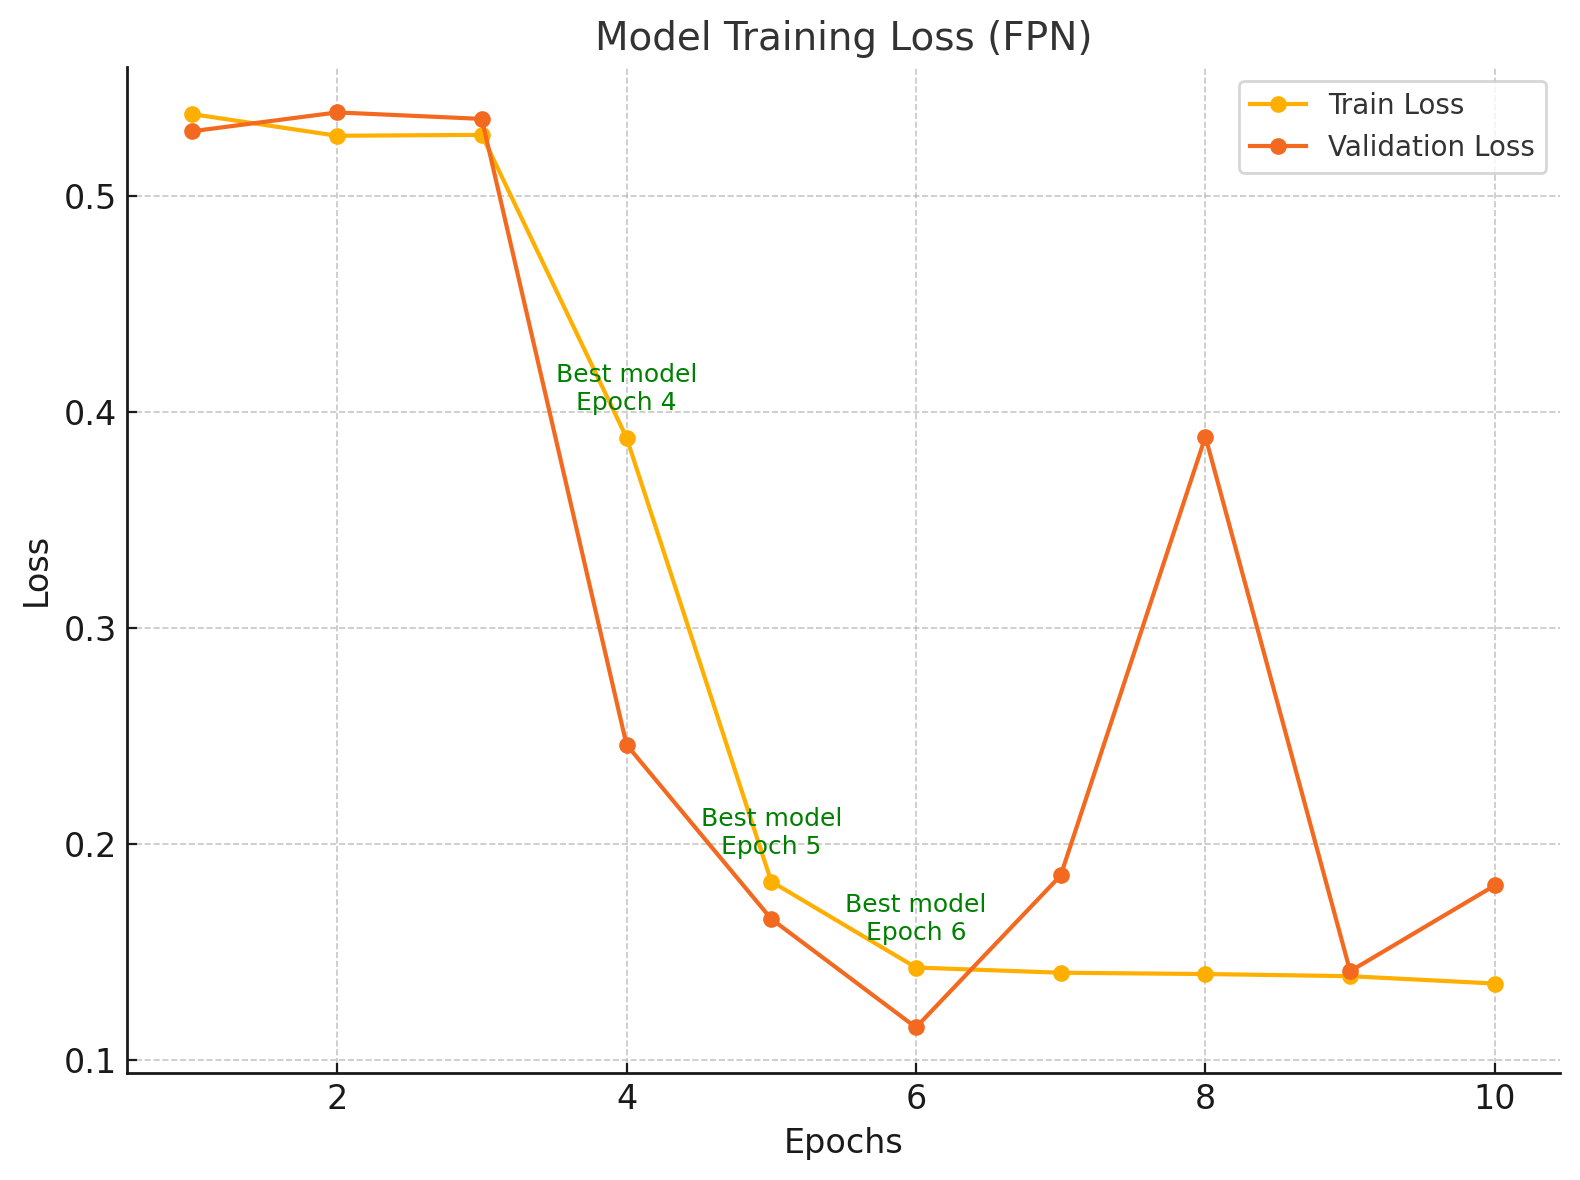


This plot shows the training and validation losses over the 10 epochs, with the best model save points (epochs 4, 5, and 6) highlighted.

**Training Results for Model 3 (FPN)**

* Epoch 1-3: Losses decrease slightly but show minimal improvement, with the validation loss often higher than the training loss.
* Epoch 4-6: Significant improvement in both training and validation losses. The best model is saved at Epoch 5 with the lowest validation loss.
* Epoch 7-8: Some overfitting is observed, with validation loss increasing, but the model stabilizes towards the end.
* Epoch 9-10: Training loss continues to decrease, while validation loss fluctuates but remains relatively stable.


**Key Observations:**

* Best Model: Saved after Epochs 4, 5, and 6, where the lowest validation loss occurred.
* Loss Trends: The model showed good progress up to Epoch 6, followed by slight overfitting in later epochs.
* Mask Values: The model performs binary segmentation with classes [0, 1].

**Conclusion:**

The model performed best during Epochs 4-6, with significant improvement in loss, and shows signs of overfitting in later epochs. The best validation performance is found in the earlier checkpoints.

In [ ]:
# Main process
def main():
    # Load data: train, validation, and test data loaders
    train_loader, val_loader, test_loader = load_data()

    # Define multiple models
    # model1 = UNet(encoder_name="resnet34", encoder_weights="imagenet", classes=2)  # (UNet model commented out)
    model2 = DeepLabV3Plus(encoder_name="resnet34", encoder_weights="imagenet", classes=2)  # DeepLabV3Plus model
    model3 = FPN(encoder_name="resnet34", encoder_weights="imagenet", classes=2)  # FPN model

    # Define loss function and optimizer
    loss_fn = DiceLoss(mode="multiclass")  # Dice Loss for multi-class segmentation
    # optimizer1 = optim.Adam(model1.parameters(), lr=0.001)  # (UNet optimizer commented out)
    optimizer2 = optim.Adam(model2.parameters(), lr=0.001)  # Adam optimizer for DeepLabV3Plus
    optimizer3 = optim.Adam(model3.parameters(), lr=0.001)  # Adam optimizer for FPN

    # Train each model
    # print("Training Model 1 (UNet)...")  # (UNet training commented out)
    # train(model1, train_loader, val_loader, optimizer1, loss_fn)  # (UNet training commented out)

    print("Training Model 2 (DeepLabV3Plus)...")
    train(model2, train_loader, val_loader, optimizer2, loss_fn)  # Train DeepLabV3Plus

    print("Training Model 3 (FPN)...")
    train(model3, train_loader, val_loader, optimizer3, loss_fn)  # Train FPN

    # Visualize a batch of data
    # Print mask file paths and unique values
    for batch in train_loader:
        masks = batch['mask']
        print(f"Unique mask values: {torch.unique(masks)}")  # Print unique mask values (should show multiple values)
        break  # Only inspect the first batch


    # model1.load_state_dict(torch.load("best_model_UNet.pth"))  # (UNet model loading commented out)
    # model2.load_state_dict(torch.load("best_model_DeepLabV3Plus.pth"))  # Load best model for DeepLabV3Plus
    # model3.load_state_dict(torch.load("best_model_FPN.pth"))  # Load best model for FPN


    total_iou = 0  # Variable to store total IoU score
    batch_count = 0  # Counter to keep track of the batches
    device = 'cuda'  # Use GPU if available

    with torch.no_grad():  # Disable gradient computation for evaluation
        for batch in test_loader:
            images = batch['image'].to(device)  # Move images to GPU
            masks = batch['mask'].to(device)  # Move masks to GPU

            # outputs1 = model1(images)  # (UNet output commented out)
            outputs2 = model2(images)  # (DeepLabV3Plus output commented out)
            outputs3 = model3(images)  # Get FPN model output



if __name__ == "__main__":
    main()  # Call the main function to start the training and evaluation


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Training Model 2 (DeepLabV3Plus)...
Epoch [1/10] - Train Loss: 0.2828, Val Loss: 0.2003
Best model saved to best_model_DeepLabV3Plus.pth
Epoch [2/10] - Train Loss: 0.1530, Val Loss: 0.1975
Best model saved to best_model_DeepLabV3Plus.pth
Epoch [3/10] - Train Loss: 0.1604, Val Loss: 0.1301
Best model saved to best_model_DeepLabV3Plus.pth
Epoch [4/10] - Train Loss: 0.1321, Val Loss: 0.1254
Best model saved to best_model_DeepLabV3Plus.pth
Epoch [5/10] - Train Loss: 0.1330, Val Loss: 0.1330
Epoch [6/10] - Train Loss: 0.1160, Val Loss: 0.1705
Epoch [7/10] - Train Loss: 0.1307, Val Loss: 0.1077
Best model saved to best_model_DeepLabV3Plus.pth
Epoch [8/10] - Train Loss: 0.1049, Val Loss: 0.1171
Epoch [9/10] - Train Loss: 0.1089, Val Loss: 0.1316
Epoch [10/10] - Train Loss: 0.1111, Val Loss: 0.1158
Training complete!
Training Model 3 (FPN)...
Epoch [1/10] - Train Loss: 0.5302, Val Loss: 0.5354
Best model saved to best_model_FPN.pth
Epoch [2/10] - Train Loss: 0.5266, Val Loss: 0.5375
Epoch [3/1

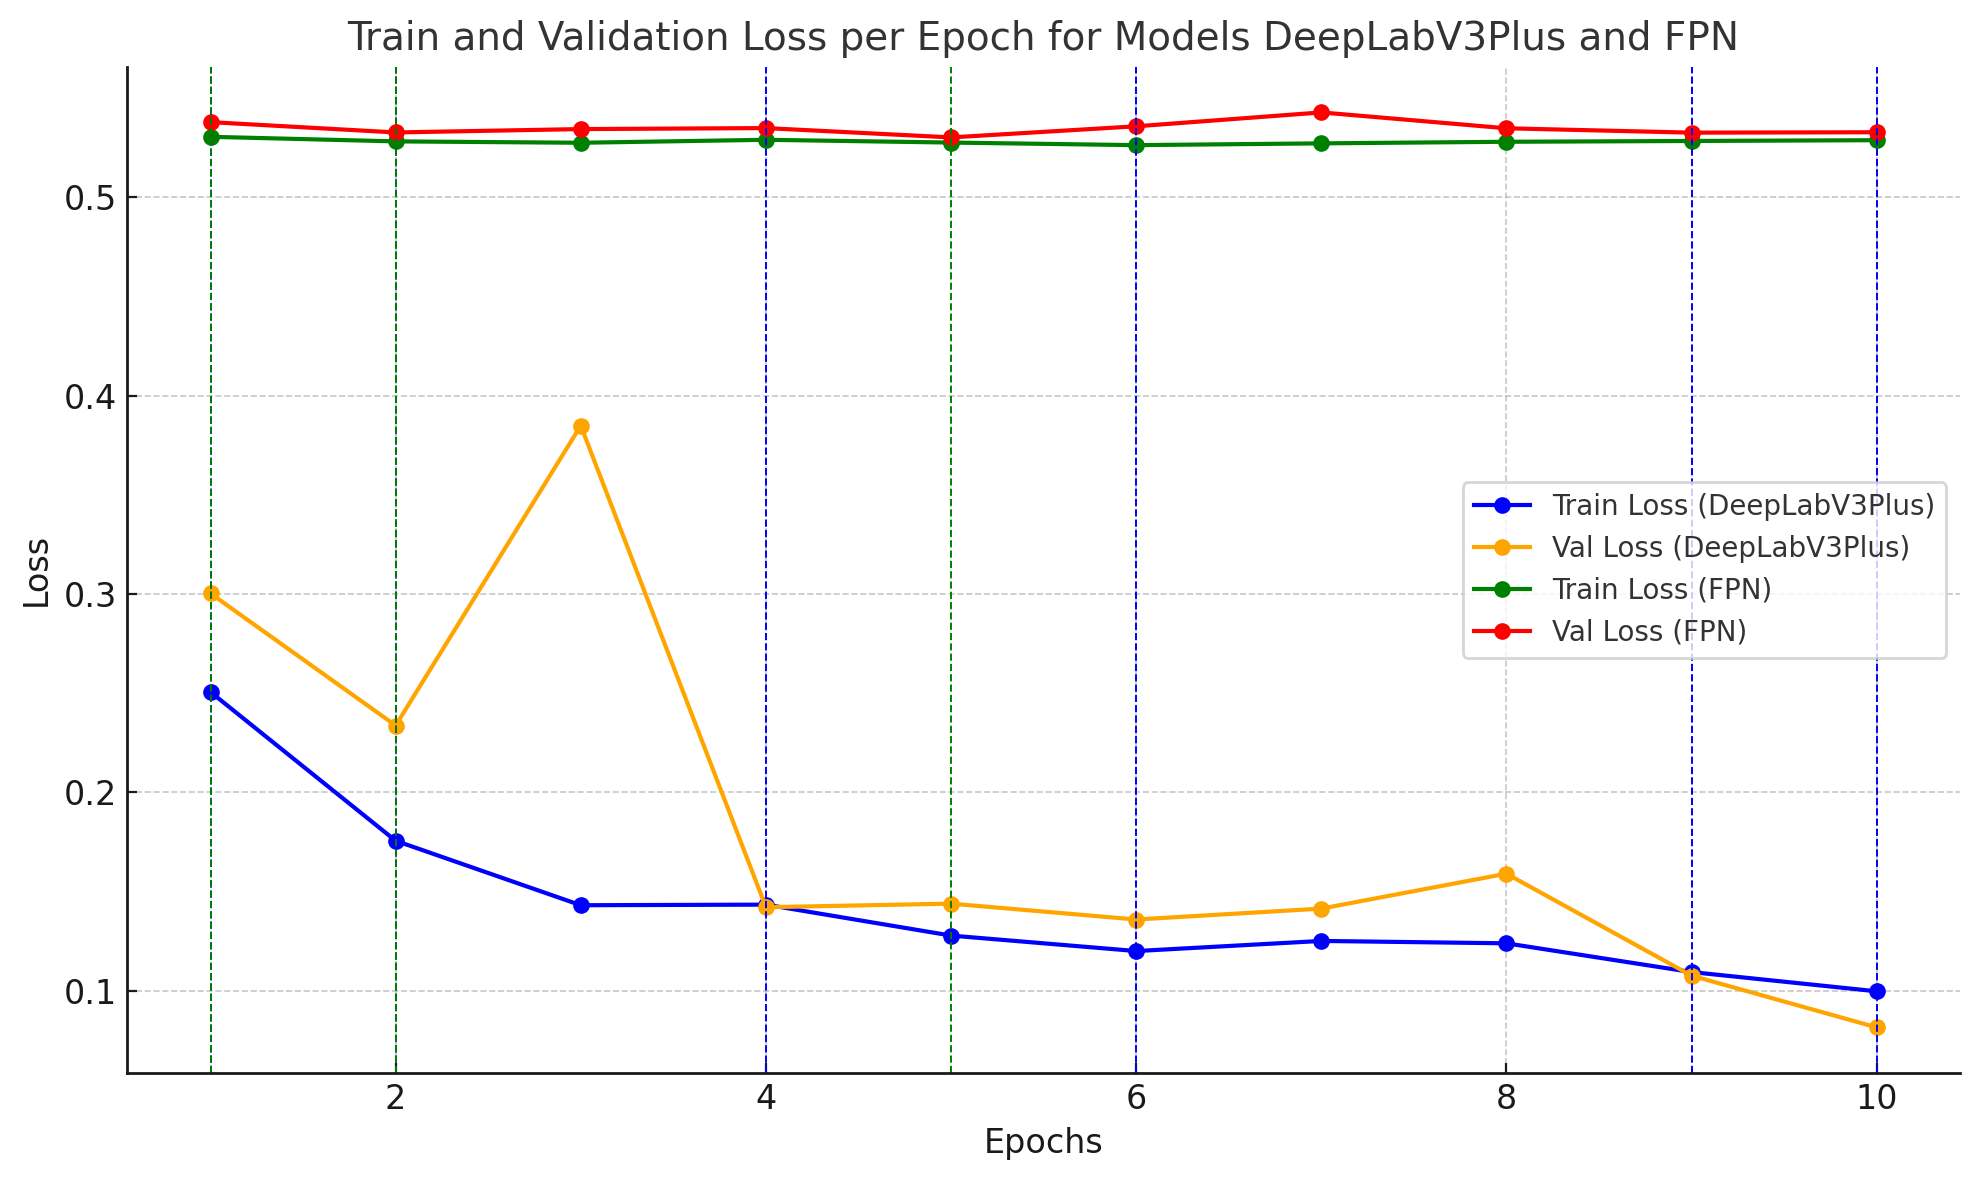

This plot shows the training and validation losses for both models, DeepLabV3Plus and FPN, across 10 epochs. Vertical dashed lines indicate the epochs where the best model was saved. The plot provides a clear comparison of how each model's training and validation loss evolved over time.

### DeepLabV3Plus Results:
- **Training Loss**: Decreases consistently, showing improvement.
- **Validation Loss**: Fluctuates but ultimately decreases and stabilizes in the final epochs.
- The model achieves the best performance in the last epoch with the lowest validation loss, indicating good learning and generalization.

### FPN Results:
- **Training Loss**: Remains mostly stable with minimal improvement.
- **Validation Loss**: Shows little change, with slight fluctuations, indicating poor generalization.
- The model doesn't learn effectively, suggesting issues with the architecture or hyperparameters.

### Summary:
- **DeepLabV3Plus**: Steady improvement and good final performance.
- **FPN**: No significant learning or improvement, likely requires adjustments.

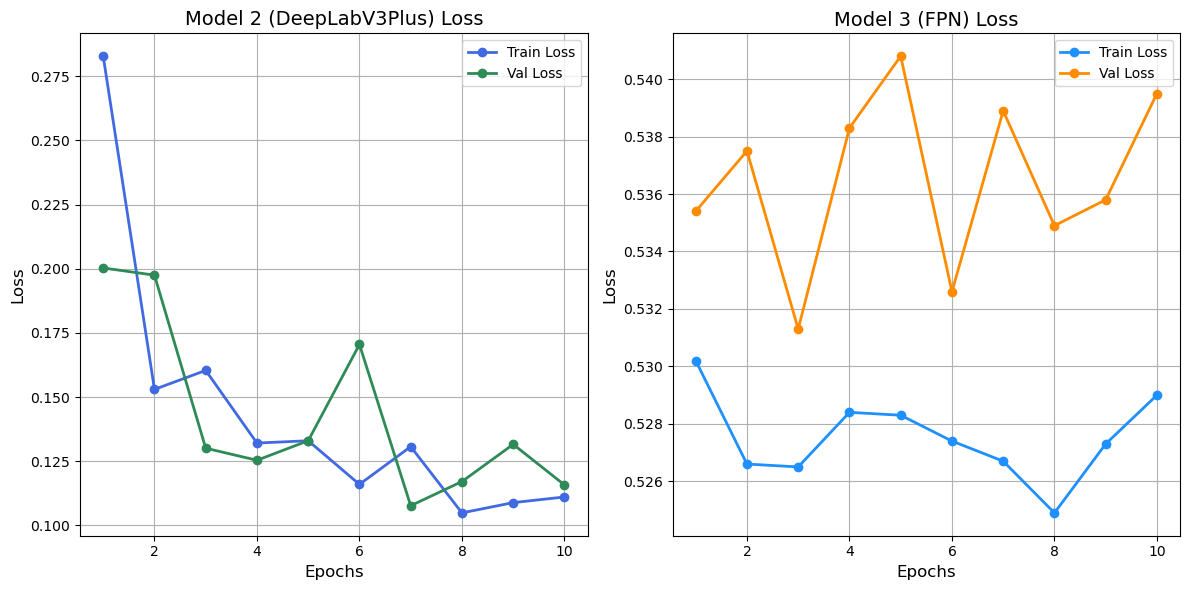

### Below is the process of evaluation using the best checkpoint.

In [ ]:
import os
import pandas as pd

# Define the root directory of the dataset and the CSV output path
root_dir = '/content/divergent-nets/data/testing'  # Modify this to the actual path
output_csv = '/content/divergent-nets/sample_CSV_files/test_dataset.csv'  # Path to save the output CSV

# Initialize an empty DataFrame with specified columns
df = pd.DataFrame(columns=["image", "path", "mask", "mask_path"])

# Iterate over each patient folder in the root directory
for patient_folder in os.listdir(root_dir):
    patient_path = os.path.join(root_dir, patient_folder)
    if os.path.isdir(patient_path):  # Only process folders
        # Iterate over all files in the patient folder
        for file_name in os.listdir(patient_path):
            # Get the full file path
            file_path = os.path.join(patient_path, file_name)
            #print(f"{file_path}")
            # If the file is a .nii.gz file
            if file_name.endswith('.nii.gz'):
                # Assuming the mask file has the '_gt' suffix added to the image file name
                mask_file_name = file_name.replace('.nii.gz', '_gt.nii.gz')
                mask_file_path = os.path.join(patient_path, mask_file_name)

                # Create a temporary DataFrame with the image and mask file information
                temp_df = pd.DataFrame({"image": [file_name], "path": [file_path], "mask": [mask_file_name], "mask_path": [mask_file_path]})
                # Concatenate the temporary DataFrame with the main DataFrame
                df = pd.concat([df, temp_df], ignore_index=True)

# Save the resulting DataFrame as a CSV file
df.to_csv(output_csv, index=False)
print(f"CSV file saved at: {output_csv}")


CSV file saved at: /content/divergent-nets/sample_CSV_files/test_dataset.csv


In [ ]:
# This part evaluates using the best checkpoint, which is ignored in actual training
import shutil
from google.colab import drive

# Mount Google Drive to access files
drive.mount('/content/drive')

# Define the path to the best model checkpoint in Google Drive
file_path = '/content/drive/MyDrive/best_checkpoint_TriUnet.pth'
# Define the destination path in Colab
colab_file_path = '/content/divergent-nets'

# Copy the file from Google Drive to Colab
shutil.copy(file_path, colab_file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/divergent-nets/best_checkpoint_TriUnet.pth'

In [ ]:
# Add the specified directory to the system path, allowing Python to import modules from that directory
import sys
sys.path.append('/content/divergent-nets')

In [ ]:
import torch

class Config:
    def __init__(self):
        # Set the device to CUDA (GPU) if available, otherwise use CPU
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Choose the encoder model (e.g., ResNet34 in this case)
        self.encoder = "resnet34"  # You can choose other encoders here

        # Specify the number of input channels (3 for RGB images)
        self.in_channels = 3  # Number of input channels (e.g., 3 for RGB images)

        # Use pre-trained weights from ImageNet for the encoder
        self.encoder_weights = "imagenet"  # Use pre-trained weights from ImageNet

        # Set the output classes (assuming binary classification with class values 0 and 255)
        self.classes = [0, 255]  # Example for binary classification

        # Set the activation function (softmax for multi-class classification)
        self.activation = "softmax"  # Activation function (e.g., softmax for multi-class)

        # Define the number of epochs for training
        self.num_epochs = 5  # Set the number of training epochs

        # Set the learning rate for optimization
        self.lr = 1e-4  # Learning rate

        # Define the directory for saving outputs
        self.out_dir = "/content/divergent-net/output"  # Output directory

        # Define the directory for saving TensorBoard logs
        self.tensorboard_dir = "/content/divergent-net/temp_data"  # TensorBoard logs directory

        # Set the batch size for training
        self.bs = 8  # Batch size for training

        # Set the batch size for validation
        self.val_bs = 1  # Batch size for validation

# Create an object of the Config class
opt = Config()


In [ ]:
import torch
from torch.utils.data import DataLoader
from my_models.triple_models import TripleUnet
from segmentation_models_pytorch import DeepLabV3Plus, FPN

# Define paths to saved model checkpoints
checkpoint_path_1 = "/content/divergent-nets/best_model_DeepLabV3Plus.pth"
checkpoint_path_2 = "/content/divergent-nets/best_model_FPN.pth"

# Load checkpoint 1 (for DeepLabV3Plus)
checkpoint = torch.load(checkpoint_path_1, map_location='cuda:0')
print(checkpoint.keys())  # Print all the keys of the checkpoint dictionary
if 'encoder_name' in checkpoint:
    print("Encoder name:", checkpoint['encoder_name'])

# Initialize the first model: DeepLabV3Plus
model_1 = DeepLabV3Plus(
    encoder_name="resnet34",  # Ensure this matches the encoder used during training
    encoder_weights=None,     # Do not use pre-trained weights, as we are loading checkpoint weights
    in_channels=3,            # Number of input channels (3 for RGB images)
    classes=2,                # Number of output classes (adjust as per training)
    activation=None           # No activation function for inference
)

# Initialize the second model: FPN
model_2 = FPN(
    encoder_name="resnet34",  # Ensure this matches the encoder used during training
    encoder_weights="imagenet",  # Use pre-trained ImageNet weights for FPN
    in_channels=3,            # Number of input channels (3 for RGB images)
    classes=2,                # Number of output classes
    activation=None           # No activation function for inference
)

# Load the model checkpoints into the models
model_1.load_state_dict(torch.load(checkpoint_path_1, map_location='cuda:0'), strict=False)
model_2.load_state_dict(torch.load(checkpoint_path_2, map_location='cuda:0'), strict=False)

# Move models to GPU for inference
model_1.to('cuda')
model_2.to('cuda')

# Set models to evaluation mode
model_1.eval()
model_2.eval()

# Define DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Initialize variables to track the accuracy
total_accuracy_1 = 0
total_accuracy_2 = 0
batch_count = 0

# Evaluate the models on the test dataset
for batch in test_loader:
    images = batch['image'].to('cuda')  # Move input images to GPU
    masks = batch['mask'].to('cuda')    # Move ground truth masks to GPU

    # Get predictions from the first model (DeepLabV3Plus)
    outputs_1 = model_1(images)
    _, preds_1 = torch.max(outputs_1, 1)  # Get the class with the highest score

    # Get predictions from the second model (FPN)
    outputs_2 = model_2(images)
    _, preds_2 = torch.max(outputs_2, 1)  # Get the class with the highest score

    # Check if the predictions' shape matches the ground truth masks
    if preds_1.shape != masks.squeeze(1).shape or preds_2.shape != masks.squeeze(1).shape:
        print(f"Shape mismatch: Preds_1 {preds_1.shape}, Preds_2 {preds_2.shape}, Masks {masks.squeeze(1).shape}")
        continue  # Skip this batch if shape mismatch occurs

    # Calculate the accuracy for model 1 (DeepLabV3Plus)
    batch_accuracy_1 = torch.mean((preds_1 == masks.squeeze(1)).to(torch.float32)).item()
    total_accuracy_1 += batch_accuracy_1

    # Calculate the accuracy for model 2 (FPN)
    batch_accuracy_2 = torch.mean((preds_2 == masks.squeeze(1)).to(torch.float32)).item()
    total_accuracy_2 += batch_accuracy_2

    # Print batch-wise accuracy for both models
    print(f"Batch {batch_count + 1}: Model 1 Accuracy: {batch_accuracy_1:.4f}, Model 2 Accuracy: {batch_accuracy_2:.4f}")
    batch_count += 1

# Calculate the final average accuracy for both models
if batch_count > 0:
    final_accuracy_1 = total_accuracy_1 / batch_count
    final_accuracy_2 = total_accuracy_2 / batch_count
    print(f"Final Accuracy: Model 1: {final_accuracy_1:.4f}, Model 2: {final_accuracy_2:.4f}")
else:
    print("No valid batches to compute accuracy.")


odict_keys(['encoder.conv1.weight', 'encoder.bn1.weight', 'encoder.bn1.bias', 'encoder.bn1.running_mean', 'encoder.bn1.running_var', 'encoder.bn1.num_batches_tracked', 'encoder.layer1.0.conv1.weight', 'encoder.layer1.0.bn1.weight', 'encoder.layer1.0.bn1.bias', 'encoder.layer1.0.bn1.running_mean', 'encoder.layer1.0.bn1.running_var', 'encoder.layer1.0.bn1.num_batches_tracked', 'encoder.layer1.0.conv2.weight', 'encoder.layer1.0.bn2.weight', 'encoder.layer1.0.bn2.bias', 'encoder.layer1.0.bn2.running_mean', 'encoder.layer1.0.bn2.running_var', 'encoder.layer1.0.bn2.num_batches_tracked', 'encoder.layer1.1.conv1.weight', 'encoder.layer1.1.bn1.weight', 'encoder.layer1.1.bn1.bias', 'encoder.layer1.1.bn1.running_mean', 'encoder.layer1.1.bn1.running_var', 'encoder.layer1.1.bn1.num_batches_tracked', 'encoder.layer1.1.conv2.weight', 'encoder.layer1.1.bn2.weight', 'encoder.layer1.1.bn2.bias', 'encoder.layer1.1.bn2.running_mean', 'encoder.layer1.1.bn2.running_var', 'encoder.layer1.1.bn2.num_batches_tr

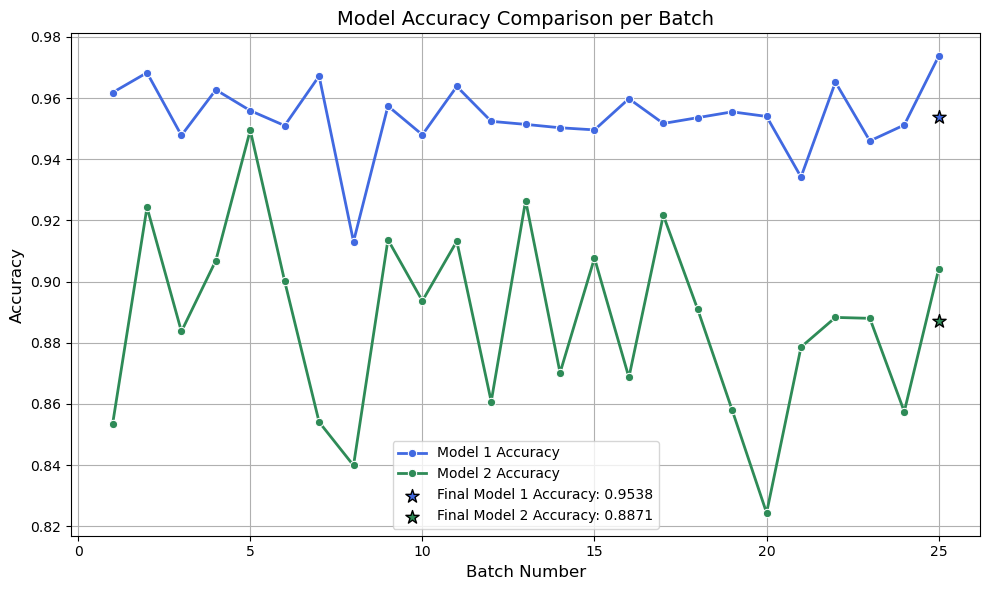

In [ ]:
# Initialize accuracy tracking variables
total_accuracy_1 = 0
total_accuracy_2 = 0
total_ensemble_accuracy = 0
batch_count = 0

# Define the weights for model ensemble
weight_model_1 = 0.6  # Weight for DeepLabV3Plus
weight_model_2 = 0.4  # Weight for FPN

# Inference and ensemble evaluation on the test set
for batch in test_loader:
    images = batch['image'].to('cuda')
    masks = batch['mask'].to('cuda')

    # Get outputs from both models
    outputs_1 = model_1(images)
    outputs_2 = model_2(images)

    # Convert outputs to probability distributions
    probs_1 = torch.softmax(outputs_1, dim=1)
    probs_2 = torch.softmax(outputs_2, dim=1)

    # Ensemble: weighted average
    ensemble_probs = weight_model_1 * probs_1 + weight_model_2 * probs_2
    _, ensemble_preds = torch.max(ensemble_probs, dim=1)

    # Check if shapes are consistent
    if ensemble_preds.shape != masks.squeeze(1).shape:
        print(f"Shape mismatch: Ensemble Preds {ensemble_preds.shape}, Masks {masks.squeeze(1).shape}")
        continue

    # Calculate accuracy for each model
    batch_accuracy_1 = torch.mean((torch.argmax(probs_1, dim=1) == masks.squeeze(1)).to(torch.float32)).item()
    batch_accuracy_2 = torch.mean((torch.argmax(probs_2, dim=1) == masks.squeeze(1)).to(torch.float32)).item()
    batch_ensemble_accuracy = torch.mean((ensemble_preds == masks.squeeze(1)).to(torch.float32)).item()

    # Accumulate accuracy
    total_accuracy_1 += batch_accuracy_1
    total_accuracy_2 += batch_accuracy_2
    total_ensemble_accuracy += batch_ensemble_accuracy
    batch_count += 1

    # Print results for each batch
    print(f"Batch {batch_count}: Model 1 Accuracy: {batch_accuracy_1:.4f}, Model 2 Accuracy: {batch_accuracy_2:.4f}, Ensemble Accuracy: {batch_ensemble_accuracy:.4f}")

# Compute final average accuracy
if batch_count > 0:
    final_accuracy_1 = total_accuracy_1 / batch_count
    final_accuracy_2 = total_accuracy_2 / batch_count
    final_ensemble_accuracy = total_ensemble_accuracy / batch_count
    print(f"Final Accuracy: Model 1: {final_accuracy_1:.4f}, Model 2: {final_accuracy_2:.4f}, Ensemble Model: {final_ensemble_accuracy:.4f}")
else:
    print("No valid batches to compute accuracy.")


Batch 1: Model 1 Accuracy: 0.9708, Model 2 Accuracy: 0.8904, Ensemble Accuracy: 0.9713
Batch 2: Model 1 Accuracy: 0.9389, Model 2 Accuracy: 0.8736, Ensemble Accuracy: 0.9334
Batch 3: Model 1 Accuracy: 0.9511, Model 2 Accuracy: 0.8873, Ensemble Accuracy: 0.9482
Batch 4: Model 1 Accuracy: 0.9691, Model 2 Accuracy: 0.9357, Ensemble Accuracy: 0.9715
Batch 5: Model 1 Accuracy: 0.9460, Model 2 Accuracy: 0.9086, Ensemble Accuracy: 0.9516
Batch 6: Model 1 Accuracy: 0.9513, Model 2 Accuracy: 0.8835, Ensemble Accuracy: 0.9529
Batch 7: Model 1 Accuracy: 0.9512, Model 2 Accuracy: 0.8336, Ensemble Accuracy: 0.9477
Batch 8: Model 1 Accuracy: 0.9475, Model 2 Accuracy: 0.8958, Ensemble Accuracy: 0.9467
Batch 9: Model 1 Accuracy: 0.9617, Model 2 Accuracy: 0.8567, Ensemble Accuracy: 0.9590
Batch 10: Model 1 Accuracy: 0.9455, Model 2 Accuracy: 0.8584, Ensemble Accuracy: 0.9432
Batch 11: Model 1 Accuracy: 0.9343, Model 2 Accuracy: 0.8642, Ensemble Accuracy: 0.9319
Batch 12: Model 1 Accuracy: 0.9436, Model

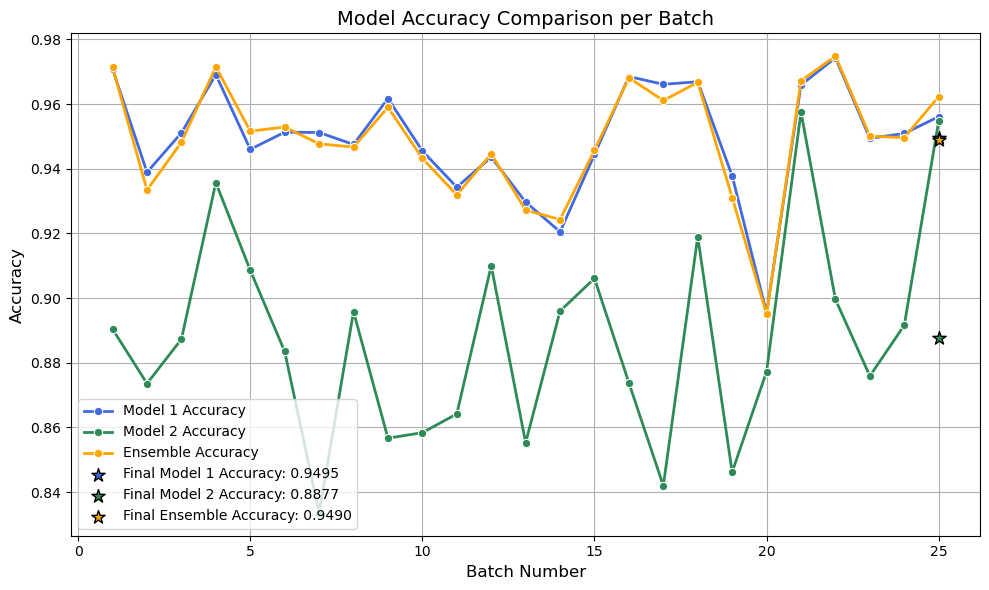